<a href="https://colab.research.google.com/github/raklugrin01/DeepLearingBasics/blob/main/ChurnModellingFiles/ChurnModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ChurnModellingFiles/Churn_Modelling.csv')

In [4]:
y = dataset.iloc[:,13]
X = dataset.iloc[:,3:13]


In [5]:
geography = pd.get_dummies(X['Geography'],drop_first=True)
gender = pd.get_dummies(X['Gender'],drop_first=True)

In [6]:
X= pd.concat([X,geography,gender],axis=1)
X = X.drop(['Geography','Gender'],axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0) 

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [9]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
!pip install keras-tuner

In [11]:
import kerastuner as kt
#function for building models for tuner
def model_builder(hp):
  model = keras.Sequential()
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 5-256
  hp_units = hp.Int('units', min_value=4, max_value=128, step=2)
  model.add(Dense(units = hp_units,kernel_initializer='he_uniform', activation = 'relu', input_dim = 11))
  model.add(Dense(units = hp_units,kernel_initializer='he_uniform', activation = 'relu'))
  

  model.add(Dense(units = 1 , kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])

  model.compile(optimizer=keras.optimizers.Adamax(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [12]:
#instatntiating the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/ktHB',
                     project_name='intro_to_kt')

In [13]:
#callback to stop at best val_loss
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [14]:
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 30 Complete [00h 00m 05s]
val_accuracy: 0.7506250143051147

Best val_accuracy So Far: 0.8600000143051147
Total elapsed time: 00h 01m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#finding the best epoch value for best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100,batch_size=10, validation_split=0.33)
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
model_history =hypermodel.fit(X_train, y_train, epochs=best_epoch,batch_size=10, validation_split=0.33)

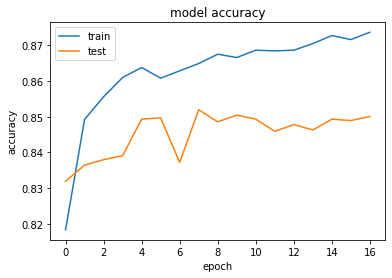

In [20]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

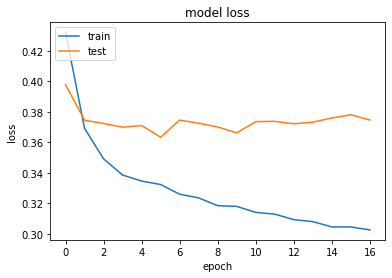

In [21]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# Predicting the Test set results
y_pred = hypermodel.predict(X_test)
y_pred = (y_pred > 0.5)


In [23]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate the Accuracy
from sklearn.metrics import accuracy_score
score=accuracy_score(y_pred,y_test)

print(score)

0.852


In [24]:
cm

array([[1512,   83],
       [ 213,  192]])